In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops



path_tr = '/content/drive/MyDrive/TZ/myte/input/xtrain.npy'
path_mask = '/content/drive/MyDrive/TZ/myte/input/ytrain.npy'
path_test = '/content/drive/MyDrive/TZ/myte/input/xtest.npy'


In [2]:
tr = np.load(path_tr)
tr_mask = np.load(path_mask)
tr.shape, tr_mask.shape

((15137, 256, 256, 1), (15137, 8))

In [82]:
a = tr_mask[3] * 255

In [83]:
make_pair = list([int(i), int(j)] for i, j in zip(a[0::2], a[1::2]))
make_pair

[[65, 7], [53, 255], [226, 248], [198, 8]]

In [84]:
mask = np.zeros_like(tr[0])
cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

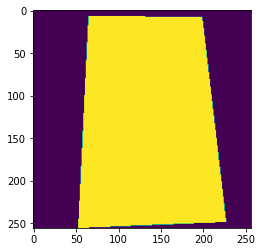

In [85]:
plt.imshow(mask.squeeze())

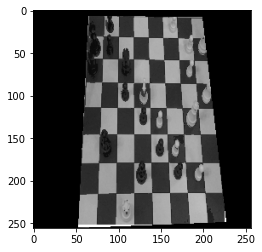

In [86]:
img = np.squeeze(tr[0])
masked_image = cv2.bitwise_and(img, mask)
plt.imshow(masked_image, cmap='gray')

In [61]:
def find_bbox(data: list) -> tuple:
    # from skimage.measure import label, regionprops    
    """
    # https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
    Label connected regions of this mask using skimage.measure.label
    Measure morphological properties of these connected regions and keep
    the bounding box (skimage.measure.regionprops). For each connected region
    a bounding box of the form (min_row, min_col, max_row, max_col) is returned.
    
    data: list, mask
    return: tuple, x1, y1, x2, y2
    """
    
    l0 = label(data)
    pr = regionprops(l0)
    return pr[0].bbox[1], pr[0].bbox[0], pr[0].bbox[4], pr[0].bbox[3]


def show_board(image: list, points: list) -> None:
    points = points * 255
    make_pair = list([int(i), int(j)] for i, j in zip(points[0::2], points[1::2]))
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)
    fb = find_bbox(mask)
    img = np.squeeze(image)
    mask = np.squeeze(mask)
    masked_image = cv2.bitwise_and(img, mask)
    
    fig, axes = plt.subplots(1,4,figsize=(14,8), sharex=True, sharey=True)

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    axes[2].imshow(masked_image, cmap='gray')
    axes[2].set_title('Mask Image')
    axes[2].axis('off')
    im = img.copy()
    cv2.rectangle(
        im, 
        (int(fb[0]), int(fb[1])),
        (int(fb[2]), int(fb[3])),
        (255,0,0),
        3
    )    
    axes[3].imshow(im, cmap='gray')
    axes[3].set_title('Bbox')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

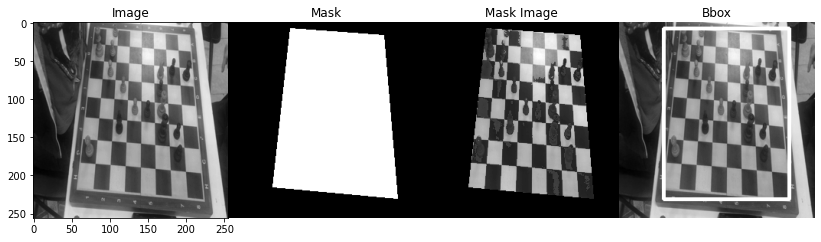

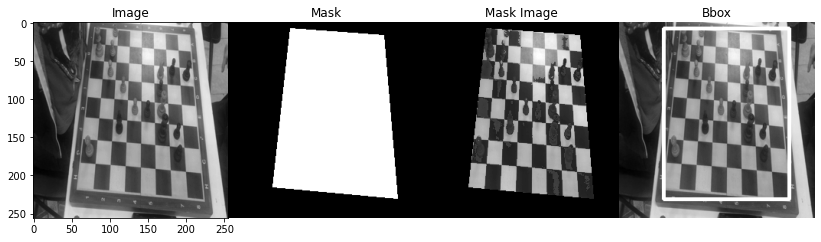

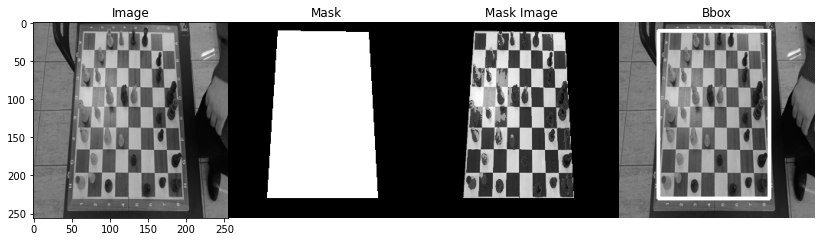

In [133]:
show_board(tr[16], tr_mask[16])
show_board(tr[116], tr_mask[116])

In [88]:
fb = find_bbox(mask)

In [97]:
type(fb)

tuple

In [60]:
pr[1].bbox

IndexError: ignored

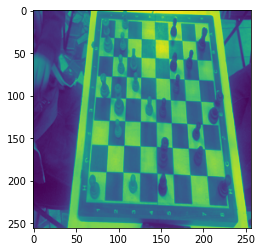

In [67]:
plt.imshow(tr[1].squeeze())

In [91]:
img = np.squeeze(tr[3])

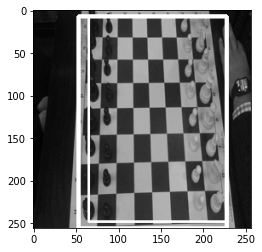

In [94]:
plt.imshow(img, cmap='gray')

In [ ]:

cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)


In [93]:
y = tr_mask[3] * 255
cv2.rectangle(img, 
              (int(fb[0]), int(fb[1])),
              (int(fb[2]), int(fb[3])),
              (255,0,0), 4

)

array([[24., 21., 22., ..., 14., 21., 18.],
       [24., 21., 22., ..., 13., 19., 15.],
       [23., 22., 23., ..., 13., 21., 22.],
       ...,
       [26., 21., 19., ..., 27., 21., 20.],
       [25., 21., 23., ..., 22., 22., 19.],
       [22., 21., 23., ..., 21., 20., 21.]], dtype=float32)

In [ ]:
img = cv2.polylines(img, [pts], True,(255,0,0), 2)

In [ ]:
y = y.astype(int)

In [ ]:
pts = np.array([[82, 11],[62, 222], [227, 228], [204, 17]], np.int32)
pts = pts.reshape((-1, 1, 2))

In [ ]:
https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/

In [ ]:
https://www.aiuai.cn/aifarm1365.html

In [ ]:
https://stackoverflow.com/questions/55667098/bounding-box-annotation-going-from-4-points-to-8